### Import libraries

In [95]:
# import libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import squarify
from scipy import stats
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


### Fonctions

In [96]:
def check_skew(df, column):
    '''fonction pour controler le skew des données'''
    skew = stats.skew(df[column])
    skewtest = stats.skewtest(df[column])
    plt.title('Distribution de la ' + column)
    sns.distplot(df[column])
    plt.show()
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

In [97]:
def rfm_clusters_stat(df):
    '''Fonction pour l'affichage des clusters'''
    df_new = df.groupby(['Cluster']).agg({
        'Recence'  : ['mean','median', 'min', 'max'],
        'Frequence': ['mean','median', 'min', 'max'],
        'Montant' : ['mean','median', 'min', 'max', 'count']
    }).round(0)
    return df_new

In [98]:
def num_outlier(df_in, col_name):
    '''fonction pour la methode IQR'''
    q1 = df_in[col_name].quantile(0.05)
    q3 = df_in[col_name].quantile(0.95)
    iqr = q3-q1 #Interquartile range
    s_bas  = q1-1.5*iqr
    s_haut = q3+1.5*iqr
    outliers_df= df_in.loc[(df_in[col_name] < s_bas) | (df_in[col_name] > s_haut)]
    index_outliers = df_in.loc[(df_in[col_name] < s_bas) | (df_in[col_name] > s_haut)].index
    df_in = pd.DataFrame(df_in.drop(index_outliers.to_list(), axis=0, inplace=True))
    print("Numero des outliers dans {} colonne: ".format(col_name), len(outliers_df))
    if len(outliers_df) > 0:
        print("Les Outliers dans la  {} colonne ont été eliminé".format(col_name),"\n")
    else:
        print("Pas d'outliers dans la {} colonne à eliminer".format(col_name),"\n")
    return df_in

In [99]:
def traitement_dates(data, colonne) :
    ''' trasnformations des dates de l'ordre %Y-%m-%d %H:%M:%Sm 
    ARGS:
        data: dataframe
        colonne: colonne qui contient la date a traiter
    '''

    data[colonne] = pd.to_datetime(data[colonne])

In [100]:
def RFM_level(df):
    """
    Classement client en fonction de leurs notes RFM.
    """
    if (df['note_recence'] >= 4) & (df['note_frequence'] >= 4) & (df['note_montant'] == 5):
        return 'Champions'

    if (df['note_recence'] >= 4) & (df['note_frequence'] >= 4) & (df['note_montant'] >= 4):
        return 'Loyaux'

    if (df['note_recence'] == 5) & (df['note_frequence'] == 1) & (df['note_montant'] >= 1):
        return 'Clients nouveaux'

    if (df['note_recence'] >= 3) & (df['note_frequence'] >= 2) & (df['note_montant'] >= 3):
        return 'Loyalistes potentiels'

    if (df['note_recence'] >= 2) & (df['note_frequence'] >= 2) & (df['note_montant'] >= 2):
        return 'A réactiver'

    if (df['note_recence'] >= 2) & (df['note_frequence'] >= 1) & (df['note_montant'] >= 1):
        return 'A risque'

    if (df['note_recence'] == 1):
        return 'Perdus'

    return 'none'

### Import des fichiers

In [101]:
# import et affichage du df
df = pd.read_csv('../data/processed/df_nc.csv')
display(df.head())

,customer_id,customer_city,customer_unique_id,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,...,price,freight_value,seller_city,seller_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,06b8999e2fba1a1fbc88172c00ba8bc7,franca,861eff4711a542e4b93843c6dd7febb0,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,...,124.99,21.88,itaquaquecetuba,SP,88b8b52d46df026a9d1ad2136a59b30b,4.0,NaN,NaN,2017-05-26 00:00:00,2017-05-30 22:34:40
1,18955e83d337fd6b2def6b18a428ac77,sao bernardo do campo,290c77bc529b7ac935b93aa66c333dc3,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,...,289.00,46.48,itajai,SC,02fc48a9efa3e3d0f1a8ea26507eeec3,5.0,NaN,NaN,2018-01-30 00:00:00,2018-02-10 22:43:29
2,4e7b3e00288586ebd08712fdd0374a03,sao paulo,060e732b5b29e8181a18229c7b0b2b5e,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,...,139.94,17.79,itaquaquecetuba,SP,5ad6695d76ee186dc473c42706984d87,5.0,NaN,NaN,2018-06-15 00:00:00,2018-06-15 12:10:59
3,b2b6027bc5c5109e529d4dc6358b12c3,mogi das cruzes,259dac757896d24d7702b9acbbff3f3c,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,...,149.94,23.36,itaquaquecetuba,SP,059a801bb31f6aab2266e672cab87bc5,5.0,NaN,NaN,2018-03-29 00:00:00,2018-04-02 18:36:47
4,4f2d8ab171c80ec8364f7c12e35b23ad,campinas,345ecd01c38d18a9036ed96c73b8d066,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,...,230.00,22.25,ibitinga,SP,8490879d58d6c5d7773f2739a03f089a,5.0,a melhor nota,O baratheon è esxelente Amo adoro o baratheon,2018-08-10 00:00:00,2018-08-17 01:59:52


In [102]:
# on trasforme le dates en type datetime
traitement_dates(df,"order_purchase_timestamp")

### Modélisation

#### Ségmentation RFM
La ségmentation RFM ou méthode RFM est une méthode de segmentation principalement développée à l'origine pour les actions de marketing.
Elle permet de cibler les offres, d'établir des segments basés sur la valeur des clients et de prévenir l'attrition en identifiant des segments à risque.

La segmentation prend en compte trois elèments:
- La Recence: date de la dernière commande
- La Frequence: le numero des commandes effectué par les clients
- Le Montant: la somme payé dans la dernier commande ou sur une période donnée.

#### Récence
On détermine pour commencer notre analyse que le jours la date d'ajourd'hui c'est 2 jours aprés la derniere date d'achat

In [103]:
# calcul de la date à utiliser
ajourdhui = df['order_purchase_timestamp'].max() + dt.timedelta(days=2)
ajourdhui

Timestamp('2018-10-19 17:30:18')

On verifie la derniere date du DF

In [104]:
print("dernier date dans le dataset: ", df['order_purchase_timestamp'].max())

dernier date dans le dataset:  2018-10-17 17:30:18


In [105]:
# création df récence
recence_df= pd.DataFrame(df.groupby(by='customer_unique_id', as_index=False)['order_purchase_timestamp'].max())
display(recence_df.head(3))

,customer_unique_id,order_purchase_timestamp
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03


In [106]:
# Calculs de jours passés à partir d'ajourdhui (variable) et derniere commande
recence_df['Recence']= recence_df['order_purchase_timestamp'].apply(lambda x: (ajourdhui - x).days)
display(recence_df.head(3))

,customer_unique_id,order_purchase_timestamp,Recence
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,162
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,165
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,587


#### Frequence

In [107]:
frequence_df = df.groupby('customer_unique_id').size().reset_index(name='Frequence')
# Sort du df par frequence
frequence_df = frequence_df.sort_values(by='Frequence')
# affichage du df
display(frequence_df.head(3))

,customer_unique_id,Frequence
0,0000366f3b9a7992bf8c76cfdf3221e2,1
61431,a3869c580baca0193761f8c48e293266,1
61429,a38552966e7362a10e7577dc3ab70ae5,1


#### Montant

In [108]:
# création df pour le montant
montant_df = df.groupby('customer_unique_id', as_index=False)['payment_value'].sum()
montant_df.columns = ['customer_unique_id', 'Montant']
display(montant_df.head(3))

,customer_unique_id,Montant
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22


### Merge des df

In [109]:
# Merge entre le 3 df
RF_df = recence_df.merge(frequence_df, on='customer_unique_id')
RFM_df = RF_df.merge(montant_df, on='customer_unique_id').drop(columns='order_purchase_timestamp')
display(RFM_df.head(3))

,customer_unique_id,Recence,Frequence,Montant
0,0000366f3b9a7992bf8c76cfdf3221e2,162,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,165,1,27.19
2,0000f46a3911fa3c0805444483337064,587,1,86.22


### Traitement des outliers

In [110]:
# contrôle outliers
for i in ["Recence", "Frequence", "Montant"]:
    num_outlier(RFM_df, i)

Numero des outliers dans Recence colonne:  0
Pas d'outliers dans la Recence colonne à eliminer 

Numero des outliers dans Frequence colonne:  1890
Les Outliers dans la  Frequence colonne ont été eliminé 

Numero des outliers dans Montant colonne:  748
Les Outliers dans la  Montant colonne ont été eliminé 


### Modélisation RFM Manuel

In [111]:
# copie du df
RFM_df_cust= RFM_df.copy()
# set de customer_unique_id comme index du df
RFM_df_cust= RFM_df_cust.set_index('customer_unique_id')
display(RFM_df_cust.head(3))

,Recence,Frequence,Montant
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,162,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,165,1,27.19
0000f46a3911fa3c0805444483337064,587,1,86.22


#### Définition des notes pour les clients

In [112]:
Image(url="https://user.oc-static.com/upload/2023/03/21/16793895608947_Screenshot%202023-03-21%20at%2010.05.50.png", width=700, height=400)

Comme base pour définir la segmentation manuel de la clientèle avec l'RFM on vas utiliser cette graphique.
On effectue la discrétisation des données en se basant sur les quantiles en veillant dont que chaque quantile contienne approximativement le même nombre des valeurs.

In [113]:
# Création nouvelle colonne 
RFM_df_cust["note_recence"]  = pd.qcut(RFM_df_cust['Recence'], 5, labels=[5, 4, 3, 2, 1])
RFM_df_cust["note_frequence"]= pd.qcut(RFM_df_cust['Frequence'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
RFM_df_cust["note_montant"] = pd.qcut(RFM_df_cust['Montant'], 5, labels=[1, 2, 3, 4, 5])

In [114]:
# création nouvelle colonne avec les 3 scores ensemble
RFM_df_cust['RFM_score'] = RFM_df_cust.note_recence.astype(str)+ RFM_df_cust.note_frequence.astype(str) + RFM_df_cust.note_montant.astype(str)
# afficha du df
display(RFM_df_cust.head(3))

,Recence,Frequence,Montant,note_recence,note_frequence,note_montant,RFM_score
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,162,1,141.90,4,1,4,414
0000b849f77a49e4a4ce2b2a4ca5be3f,165,1,27.19,4,1,1,411
0000f46a3911fa3c0805444483337064,587,1,86.22,1,1,2,112


In [115]:
# création variable pour le cluters
RFM_df_cust["Cluster"] = RFM_df_cust.apply(RFM_level, axis=1)

In [116]:
# Statistiques par typologie de client
RFMStats = RFM_df_cust[["Cluster", "Recence", "Frequence", "Montant"]].groupby("Cluster").agg(['mean','median', 'min', 'max', 'count'])
RFMStats['Ratio']= (100*RFMStats['Montant']["count"]/RFMStats['Montant']["count"].sum()).round(2)
# affichage du df
display(RFMStats)

Recence                         Frequence         \
                             mean median  min  max  count      mean median   
Cluster                                                                      
A risque               251.910813  250.0   46  435  22694  1.020622    1.0   
A réactiver            293.994670  328.0   49  435  20639  1.159843    1.0   
Champions              141.966297  144.0    2  229   4332  1.807018    2.0   
Clients nouveaux        95.900081   92.0   38  144   3703  1.000000    1.0   
Loyalistes potentiels  200.174739  213.0    2  319  20379  1.150743    1.0   
Loyaux                 142.664640  146.0   18  229   3125  1.350080    1.0   
Perdus                 526.363930  519.0  436  774  18586  1.144302    1.0   

                                         Montant                            \
                      min max  count        mean   median     min      max   
Cluster                                                                      
A risque                1   3  22694   90.608536   49.020    0.00  1425.56   
A réactiver             1   3  20639  152.889839   84.120   55.15  1427.04   
Champions               1   3   4332  467.312158  380.445  223.54  1426.58   
Clients nouveaux        1   1   3703  145.218366  103.240   13.38  1391.35   
Loyalistes potentiels   1   3  20379  214.236936  148.350   88.07  1427.58   
Loyaux                  1   3   3125  174.901664  172.570  136.90   223.36   
Perdus                  1   3  18586  164.787240  106.970    0.00  1426.81   

                              Ratio  
                       count         
Cluster                              
A risque               22694  24.28  
A réactiver            20639  22.08  
Champions               4332   4.64  
Clients nouveaux        3703   3.96  
Loyalistes potentiels  20379  21.81  
Loyaux                  3125   3.34  
Perdus                 18586  19.89

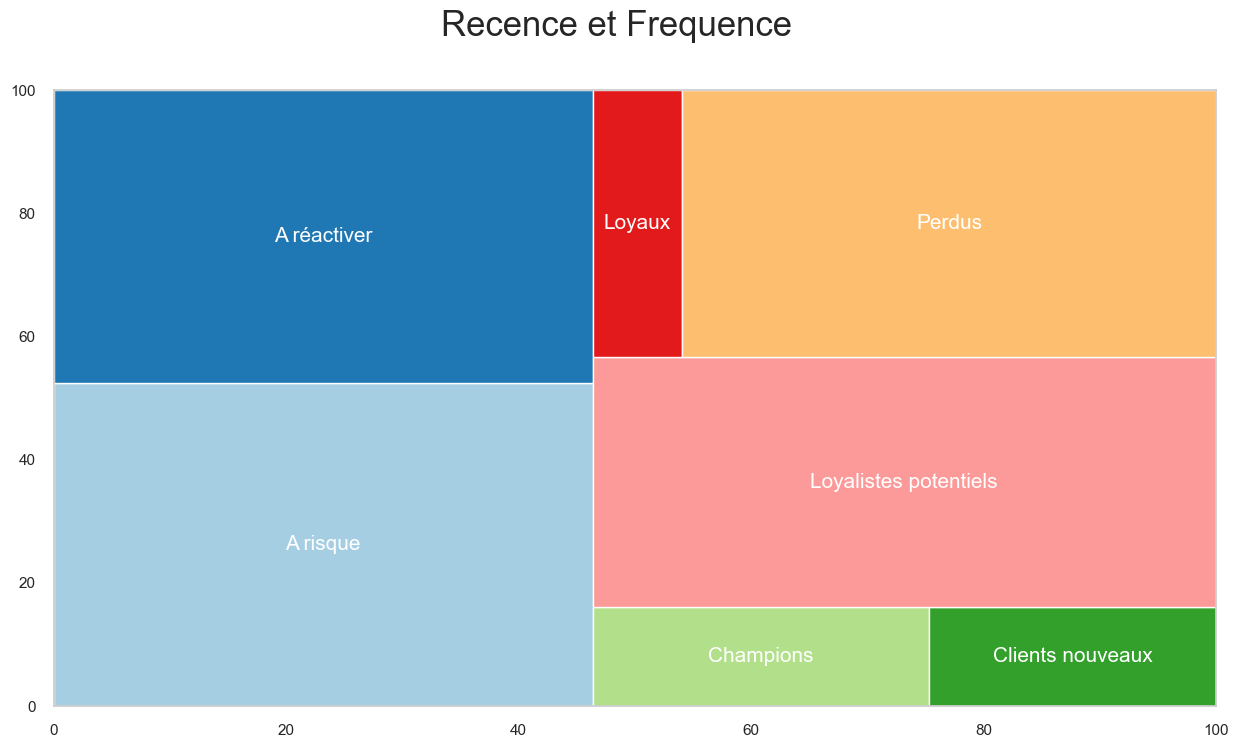

In [117]:
# Treemap Recence et Frequence
plt.figure(figsize=(15,8))
plt.rc('font', size=15)
squarify.plot(sizes=RFMStats["Recence"]["count"],text_kwargs = {'fontsize': 15, 'color': 'white'},  label=RFMStats.index,color = sns.color_palette("Paired"))
plt.suptitle("Recence et Frequence", fontsize=25);

### Modélisation ML

#### K-Means
K-means est un algorithme de regroupement de données largement utilisé dans l'analyse des données et l'apprentissage automatique. Son objectif principal est de diviser un ensemble de données en un certain nombre de groupes compacts et mutuellement exclusifs, appelés clusters.

In [118]:
# création nouvelle variable pour le clustering 
RFM_df_k= RFM_df.copy()
RFM_df_k= RFM_df.set_index('customer_unique_id')
display(RFM_df_k.head(3))

,Recence,Frequence,Montant
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,162,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,165,1,27.19
0000f46a3911fa3c0805444483337064,587,1,86.22


Skewness, ou asymétrie en français, est une mesure statistique qui décrit l'asymétrie de la distribution des valeurs d'une variable par rapport à sa moyenne. En d'autres termes, elle indique si la distribution des valeurs est symétrique ou non.

- Une skewness proche de zéro indique une distribution relativement symétrique.
- Une skewness positive indique une queue de distribution plus longue du côté droit, ce qui signifie que les valeurs élevées sont plus fréquentes.
- Une skewness négative indique une queue de distribution plus longue du côté gauche, ce qui signifie que les valeurs faibles sont plus fréquentes.

In [119]:
# affichage skew
print(stats.skew(RFM_df_k['Recence']))
print(stats.skew(RFM_df_k['Frequence']))
print(stats.skew(RFM_df_k['Montant']))

0.4462550475069925
2.776597058676708
3.00042062653985


In [120]:
# création nouvelle variable
df_RFM_log = RFM_df_k.copy()

In [121]:
df_RFM_log['Frequence'] = np.log(df_RFM_log['Frequence'] + 0.01)
df_RFM_log['Montant'] = np.log(df_RFM_log["Montant"] + 0.01)

In [122]:
# init standardScaler
scaler = StandardScaler()

In [123]:
# scaling des valeurs et conversion en df
df_RFM_log_scaled= scaler.fit_transform(df_RFM_log)
df_RFM_log_scaled_df= pd.DataFrame(df_RFM_log_scaled, 
                                   columns=['Recence', 
                                            'Frequence', 
                                            'Montant'])
display(df_RFM_log_scaled_df.head(3))

,Recence,Frequence,Montant
0,-0.831970,-0.379937,0.249190
1,-0.812406,-0.379937,-1.722107
2,1.939675,-0.379937,-0.345280


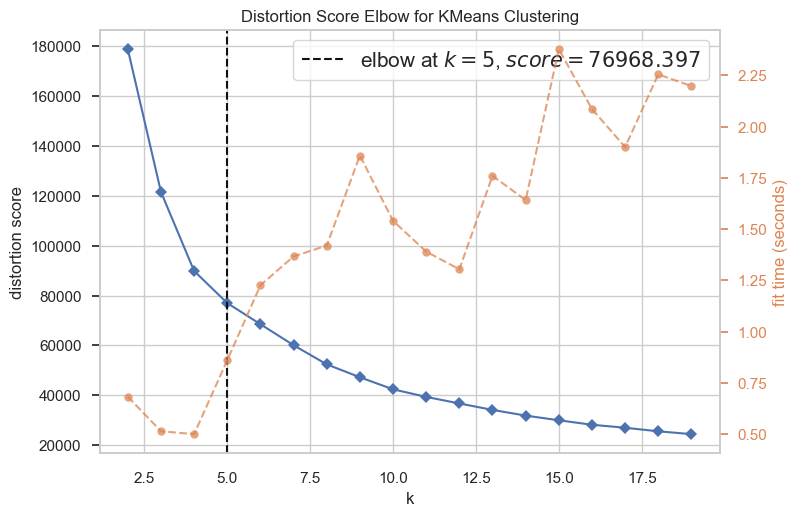

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [124]:
# Méthode du coude
k_means = KMeans(n_init=10,
                 init='k-means++', 
                 max_iter=200)
elbow = KElbowVisualizer(k_means, 
                         k=(2, 20))
elbow.fit(df_RFM_log_scaled_df)
elbow.show()

In [125]:
# fit du nombre de clusters trouvées
kmeans= KMeans(n_clusters=elbow.elbow_value_,
               n_init=10, 
               init='k-means++', 
               max_iter=300)
kmeans.fit(df_RFM_log_scaled_df)

KMeans(n_clusters=5, n_init=10)

### Silouhette score

In [126]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [127]:
# Calcul des scores de silhouette pour chaque échantillon
silhouette_vals = silhouette_samples(df_RFM_log_scaled_df, kmeans.labels_)

In [128]:
# Obtenir le score de silhouette moyen pour le clustering
silhouette_avg = silhouette_score(df_RFM_log_scaled_df, kmeans.labels_)

In [129]:
elbow_value = elbow.elbow_value_

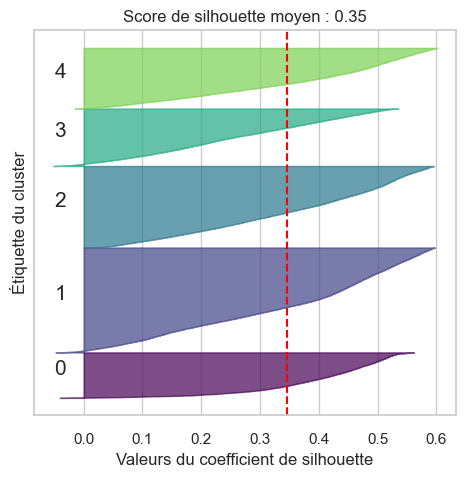

In [130]:
# création graphique
plt.figure(figsize=(12, 5))

# calcul des scores de silhouette pour chaque échantillon
y_lower = 10
for i in range(elbow_value):
    cluster_silhouette_vals = silhouette_vals[kmeans.labels_ == i]
    cluster_silhouette_vals.sort()
    y_upper = y_lower + len(cluster_silhouette_vals)
    color = plt.cm.viridis(float(i) / elbow_value)
    plt.subplot(1, 2, 1)  # Subplot on the left
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, facecolor=color, edgecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * len(cluster_silhouette_vals), str(i))
    y_lower = y_upper + 10

plt.title("Diagramme de silhouette pour chaque cluster")
plt.xlabel("Valeurs du coefficient de silhouette")
plt.ylabel("Étiquette du cluster")

# Tracer le score de silhouette moyen
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.yticks([])
plt.title("Score de silhouette moyen : {:.2f}".format(silhouette_avg))
plt.xlabel("Valeurs du coefficient de silhouette")

plt.show()

#### Analyse cluster - KMeans

In [131]:
# creation nouveaux df avec les clusters
RFM_df_cl= RFM_df_k.copy()
RFM_df_cl['Cluster'] = kmeans.labels_

In [132]:
# affichage stats des clusters
display(rfm_clusters_stat(RFM_df_cl))

Recence                  Frequence                Montant         \
           mean median  min  max      mean median min max    mean median   
Cluster                                                                    
0         288.0  269.0    2  774       2.0    2.0   2   3   338.0  265.0   
1         203.0  209.0   46  354       1.0    1.0   1   2    61.0   60.0   
2         169.0  169.0    2  301       1.0    1.0   1   1   226.0  168.0   
3         418.0  398.0  273  745       1.0    1.0   1   1   255.0  186.0   
4         480.0  472.0  336  774       1.0    1.0   1   3    68.0   66.0   

                              
          min     max  count  
Cluster                       
0        17.0  1426.0  12145  
1         0.0   114.0  28010  
2        90.0  1428.0  21770  
3        98.0  1427.0  15335  
4         0.0   176.0  16198

Cluster 0 = Champions
Cluster 1 = Loyaux
Cluster 2 = Clients nouveaux
Cluster 3 = A risque
Cluster 4 = Clients perdus

**Classement des clusters**


In [133]:
# transformation en dataframe
df_stat_RFM= pd.DataFrame(rfm_clusters_stat(RFM_df_cl))

Text(0.5, 0.98, 'Clusters des Clients')

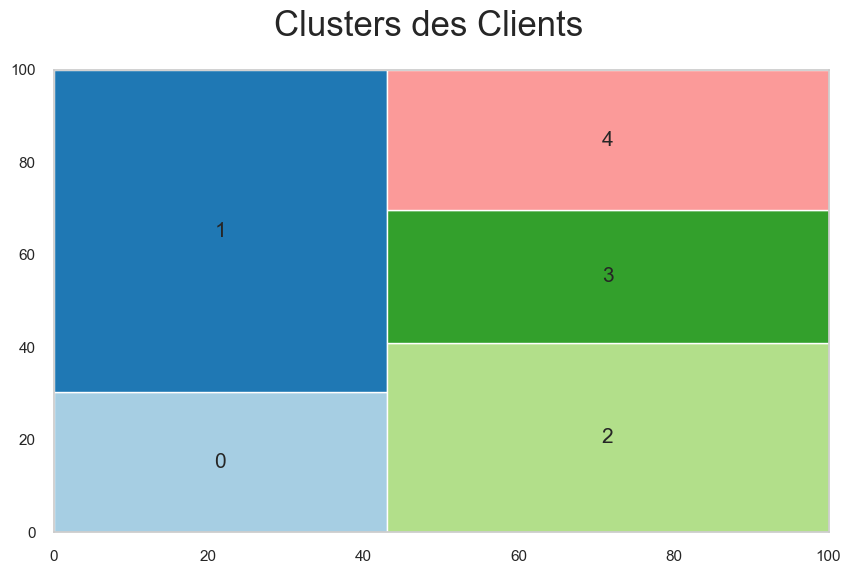

In [134]:
# affichage clusters
plt.figure(figsize=(10, 6))
squarify.plot(sizes=df_stat_RFM["Montant"]["count"],
              label=df_stat_RFM.index, 
              color = sns.color_palette("Paired"))
plt.suptitle("Clusters des Clients", 
             fontsize=25)

In [135]:
# sauvegarde du df
RFM_df_cl.to_csv('../data/processed/RFM_clust.csv', index=False)

#### DBScan
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) est un algorithme de regroupement de données basé sur la densité. Contrairement à K-means qui nécessite de spécifier le nombre de clusters à l'avance, DBSCAN peut identifier le nombre de clusters automatiquement en se basant sur la densité des données.

In [136]:
# Selection des colonnes
RFM_df_k_1 = RFM_df_k.copy()
X = RFM_df_k_1[['Recence', 'Frequence', 'Montant']]

In [137]:
# scaling des données
X_scaled = scaler.fit_transform(X)

In [138]:
# Init DBScan
dbscan = DBSCAN(eps=0.5, min_samples=5)  
# Fitting DBSCAN
clusters = dbscan.fit_predict(X_scaled)
# Ajout label cluster dans le df
RFM_df_k_1['Cluster'] = clusters

In [139]:
# affichage stats des clusters
display(rfm_clusters_stat(RFM_df_k_1))

Recence                  Frequence                Montant         \
           mean median  min  max      mean median min max    mean median   
Cluster                                                                    
-1        723.0  742.0  565  764       2.0    2.0   1   3   862.0  934.0   
 0        290.0  270.0    2  774       1.0    1.0   1   1   143.0   99.0   
 1        289.0  270.0    2  652       2.0    2.0   2   2   309.0  244.0   
 2        280.0  265.0   15  652       3.0    3.0   3   3   483.0  427.0   
 3        743.0  742.0  738  774       2.0    2.0   2   2   256.0  265.0   
 4        742.0  743.0  739  745       1.0    1.0   1   1   645.0  659.0   

                               
           min     max  count  
Cluster                        
-1         0.0  1424.0     27  
 0         0.0  1428.0  81207  
 1        10.0  1424.0  10325  
 2        17.0  1426.0   1866  
 3        34.0   501.0     24  
 4       594.0   674.0      9

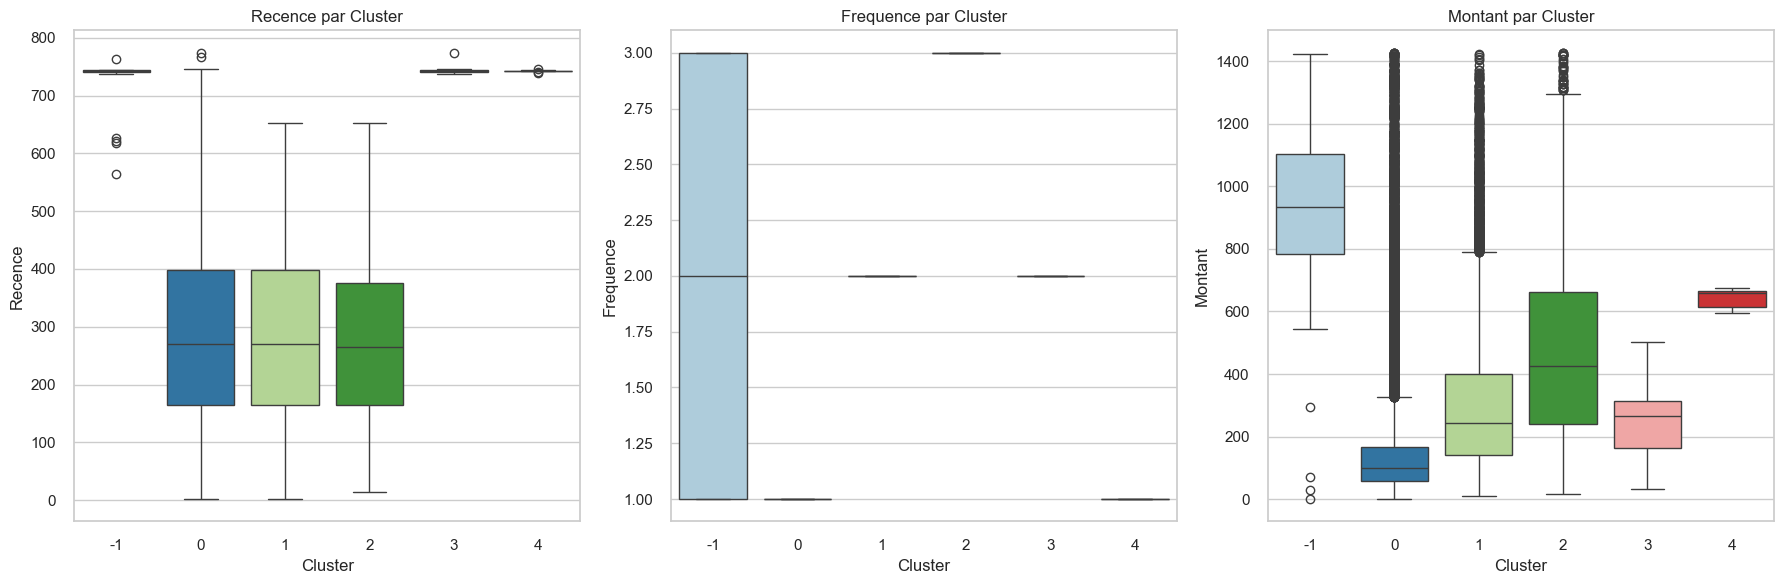

In [140]:
# creation graphique boxplot
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
color_palette = sns.color_palette("Paired", n_colors=6)

for i, column in enumerate(['Recence', 'Frequence', 'Montant']):
    sns.boxplot(x='Cluster', y=column, data=RFM_df_k_1, ax=axes[i], palette=color_palette)
    axes[i].set_title(f'{column.capitalize()} par Cluster')

plt.tight_layout()
plt.show()